In [1]:
import tensorflow as tf

# IMPORTANTE: Dejad este conjunto de lineas #
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################

Num GPUs Available:  2


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
datapath = "data/pvpcdata.csv"
day = 24

In [4]:
df = pd.read_csv(datapath, sep = ";")

In [5]:
#Due to the hour format is between 0 to 23, we need to transform it
for i in df.index:
        df.at[i, 'hour'] = df.at[i, 'hour'] - 1

In [6]:
#To keep only valid valued, not the unusual ones
df = df.loc[df['hour'] < 24]

In [7]:
cols = ["year","month","day"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [8]:
df.head()

,year,month,day,hour,price,date
0,2017,1,1,0,58.82,2017-1-1
1,2017,1,1,1,58.23,2017-1-1
2,2017,1,1,2,51.95,2017-1-1
3,2017,1,1,3,47.27,2017-1-1
4,2017,1,1,4,46.90,2017-1-1


In [9]:
df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ":00:00")

[Text(0.5, 1.0, 'Energy prices per hour at the last day')]

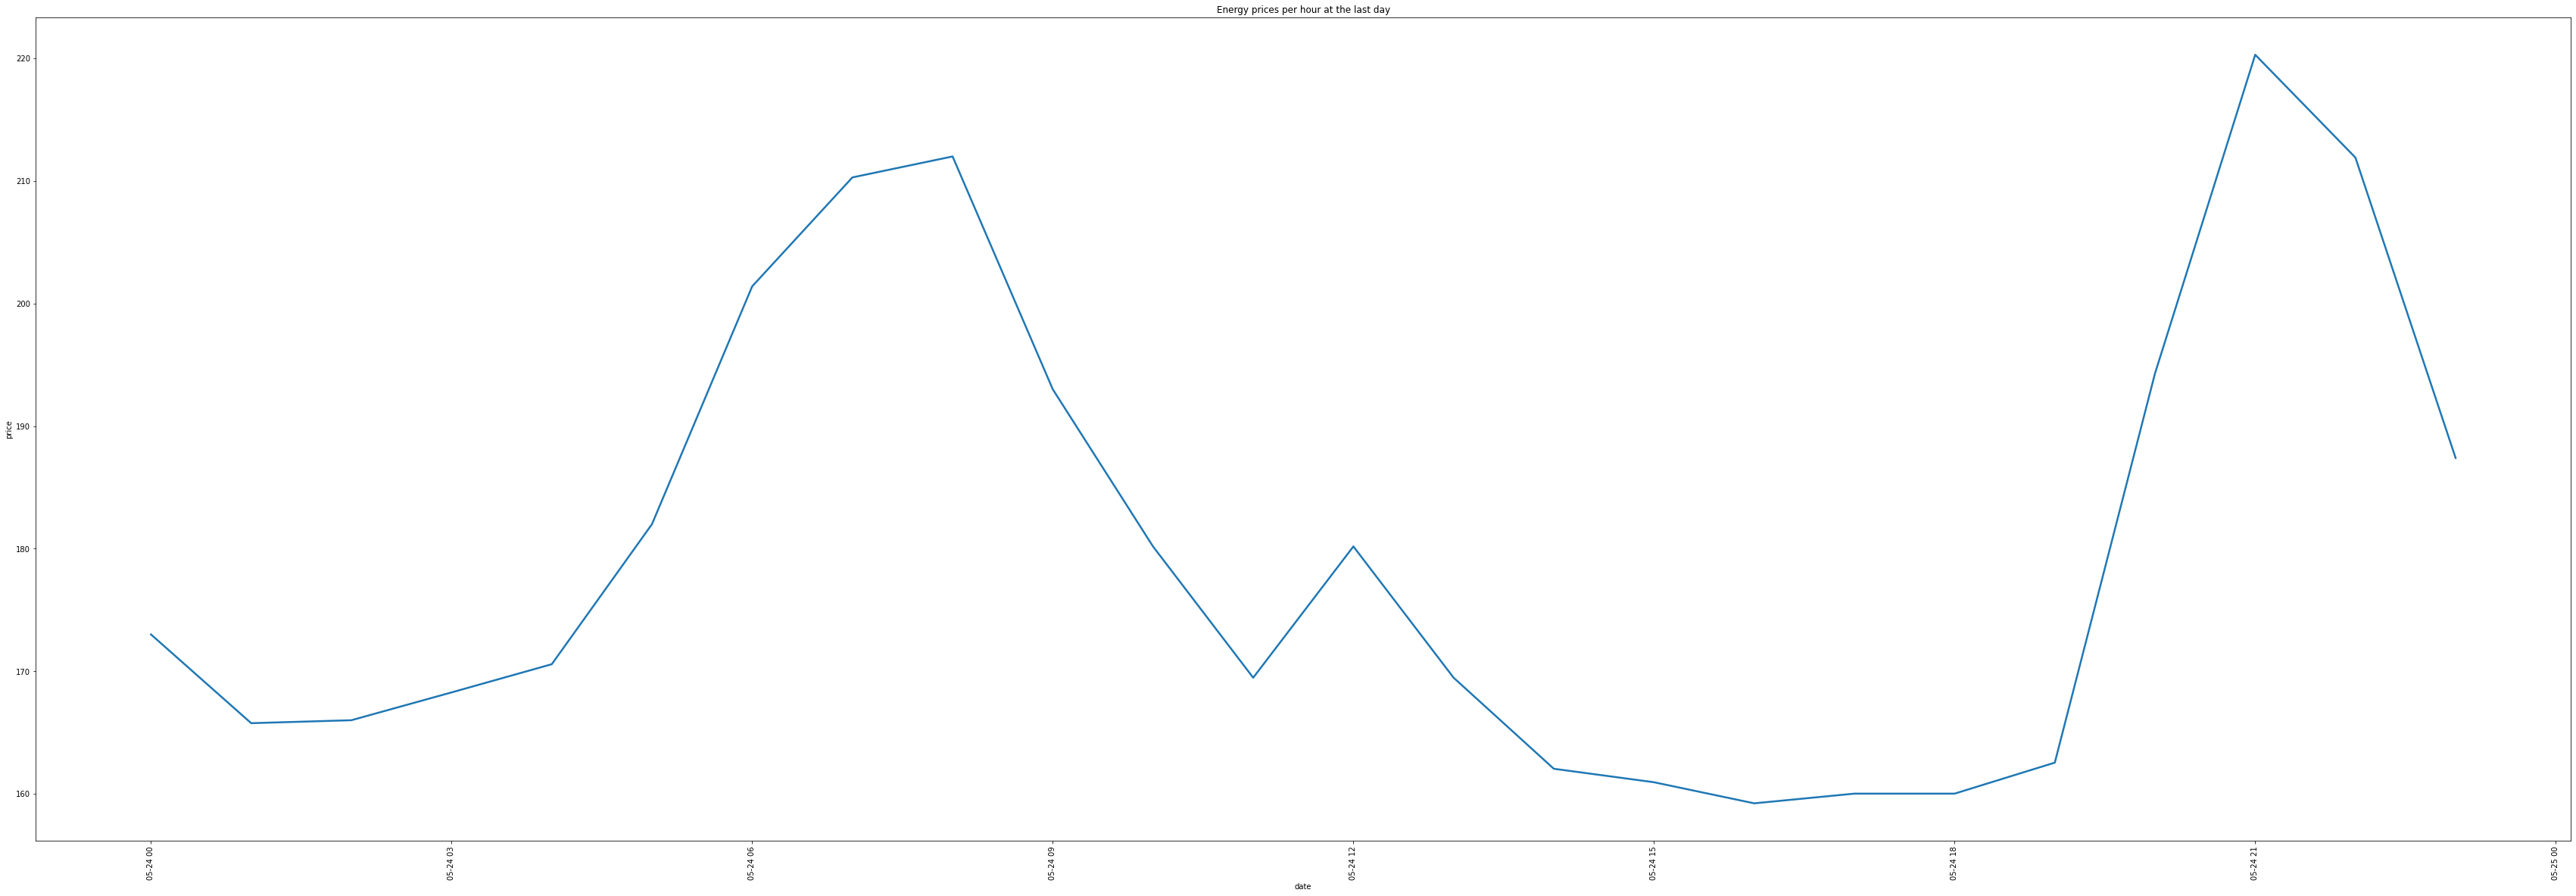

In [10]:
fig, ax = plt.subplots(figsize=(60,20))
plt.xticks(rotation=90)
sns.lineplot(x = 'date', y = 'price', data = df.tail(day), linewidth = 2.5, ax = ax).set(title='Energy prices per hour at the last day')

In [11]:
df = df[['date', 'price']]

In [12]:
date = df.pop('date')

In [13]:
timestamp = date.map(datetime.datetime.timestamp)

In [14]:
sec_day = 24*60*60
sec_year = 365.2425 * day
sec_week = 7 * sec_day

df['day_sin'] = np.sin(timestamp * (2*np.pi / sec_day))
df['day_cos'] = np.cos(timestamp * (2*np.pi / sec_day))
df['week_sin'] = np.cos(timestamp * (2*np.pi / sec_week))
df['week_cos'] = np.cos(timestamp * (2*np.pi / sec_week))
df['year_sin'] = np.sin(timestamp * (2*np.pi / sec_year))
df['year_cos'] = np.cos(timestamp * (2*np.pi / sec_year))

In [15]:
labels = df['price']
features = df.iloc[:,1:7]

In [16]:
x = features
y = np.ravel(labels)

In [17]:
x_train, x_aux, y_train, y_aux = train_test_split(x, y, test_size = 0.3, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_aux, y_aux, test_size = 0.33, shuffle=False)

In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((33108, 6), (33108,), (9507, 6), (9507,), (4683, 6), (4683,))

In [19]:
def build_model_dense():
    model = tf.keras.Sequential()
    tf.keras.layers.Input(shape = len(df.columns) - 1, name='input')
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [20]:
def build_model_lstm():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((6, 1)))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [21]:
def build_model_cnn():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((6, 1)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [22]:
def build_model_gru():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((6, 1)))
    model.add(tf.keras.layers.GRU(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [23]:
model_dense = build_model_dense()
model_lstm = build_model_lstm()
model_cnn = build_model_cnn()
model_gru = build_model_gru()

2022-06-07 10:42:37.721704: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 10:42:38.751449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17761 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5b:00.0, compute capability: 7.0
2022-06-07 10:42:38.752658: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 26273 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d7:00.0, compute capability: 7.0


In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='auto', restore_best_weights=True, patience=15)

In [25]:
history_dense = model_dense.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 200,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/200
1035/1035 [==============================] - 5s 5ms/step - loss: 801.0328 - mae: 20.5538 - mse: 801.0328 - val_loss: 37653.9297 - val_mae: 181.5113 - val_mse: 37653.9297
Epoch 2/200
1035/1035 [==============================] - 5s 5ms/step - loss: 114.6189 - mae: 7.9141 - mse: 114.6189 - val_loss: 38350.8750 - val_mae: 183.3742 - val_mse: 38350.8750
Epoch 3/200
1035/1035 [==============================] - 5s 5ms/step - loss: 116.9378 - mae: 7.9368 - mse: 116.9378 - val_loss: 38396.4844 - val_mae: 183.4954 - val_mse: 38396.4844
Epoch 4/200
1035/1035 [==============================] - 5s 5ms/step - loss: 117.3707 - mae: 7.9488 - mse: 117.3707 - val_loss: 38486.6602 - val_mae: 183.7388 - val_mse: 38486.6602
Epoch 5/200
1035/1035 [==============================] - 5s 5ms/step - loss: 117.6769 - mae: 7.9493 - mse: 117.6769 - val_loss: 38499.6133 - val_mae: 183.7813 - val_mse: 38499.6133
Epoch 6/200
1035/1035 [==============================] - 5s 5ms/step - loss: 117.3548 - mae: 7

In [26]:
history_lstm = model_lstm.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 200,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/200


2022-06-07 10:45:26.498922: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


1035/1035 [==============================] - 10s 8ms/step - loss: 309.8651 - mae: 11.1772 - mse: 309.8651 - val_loss: 37613.8750 - val_mae: 181.2784 - val_mse: 37613.8750
Epoch 2/200
1035/1035 [==============================] - 8s 8ms/step - loss: 116.0187 - mae: 7.8957 - mse: 116.0187 - val_loss: 37595.5781 - val_mae: 181.2299 - val_mse: 37595.5781
Epoch 3/200
1035/1035 [==============================] - 8s 8ms/step - loss: 115.0804 - mae: 7.8541 - mse: 115.0804 - val_loss: 37461.9258 - val_mae: 180.8717 - val_mse: 37461.9258
Epoch 4/200
1035/1035 [==============================] - 8s 8ms/step - loss: 117.2827 - mae: 7.9905 - mse: 117.2827 - val_loss: 37873.5898 - val_mae: 181.9796 - val_mse: 37873.5898
Epoch 5/200
1035/1035 [==============================] - 7s 7ms/step - loss: 118.7948 - mae: 8.0245 - mse: 118.7948 - val_loss: 37750.1953 - val_mae: 181.6564 - val_mse: 37750.1953
Epoch 6/200
1035/1035 [==============================] - 8s 7ms/step - loss: 121.3466 - mae: 8.1534 - mse

In [27]:
history_cnn = model_cnn.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 200,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/200
1035/1035 [==============================] - 7s 6ms/step - loss: 445.0962 - mae: 13.7387 - mse: 445.0962 - val_loss: 37175.4727 - val_mae: 180.1914 - val_mse: 37175.4727
Epoch 2/200
1035/1035 [==============================] - 6s 6ms/step - loss: 104.9336 - mae: 7.5400 - mse: 104.9336 - val_loss: 37160.2617 - val_mae: 180.1618 - val_mse: 37160.2617
Epoch 3/200
1035/1035 [==============================] - 6s 5ms/step - loss: 104.6682 - mae: 7.5364 - mse: 104.6682 - val_loss: 37166.7617 - val_mae: 180.1805 - val_mse: 37166.7617
Epoch 4/200
1035/1035 [==============================] - 6s 5ms/step - loss: 104.7068 - mae: 7.5385 - mse: 104.7068 - val_loss: 37178.5547 - val_mae: 180.2127 - val_mse: 37178.5547
Epoch 5/200
1035/1035 [==============================] - 6s 5ms/step - loss: 104.7975 - mae: 7.5418 - mse: 104.7975 - val_loss: 37192.1406 - val_mae: 180.2494 - val_mse: 37192.1406
Epoch 6/200
1035/1035 [==============================] - 6s 5ms/step - loss: 104.9041 - mae: 7

In [28]:
history_gru = model_gru.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = 200,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/200
1035/1035 [==============================] - 9s 8ms/step - loss: 304.6169 - mae: 11.2265 - mse: 304.6169 - val_loss: 38008.6289 - val_mae: 182.3409 - val_mse: 38008.6289
Epoch 2/200
1035/1035 [==============================] - 8s 7ms/step - loss: 122.4519 - mae: 8.1827 - mse: 122.4519 - val_loss: 37748.1016 - val_mae: 181.6446 - val_mse: 37748.1016
Epoch 3/200
1035/1035 [==============================] - 8s 7ms/step - loss: 116.3196 - mae: 7.9254 - mse: 116.3196 - val_loss: 37105.7305 - val_mae: 179.9415 - val_mse: 37105.7305
Epoch 4/200
1035/1035 [==============================] - 8s 7ms/step - loss: 115.6959 - mae: 7.9799 - mse: 115.6959 - val_loss: 38010.6328 - val_mae: 182.4242 - val_mse: 38010.6328
Epoch 5/200
1035/1035 [==============================] - 7s 7ms/step - loss: 114.3660 - mae: 7.8068 - mse: 114.3660 - val_loss: 38126.8945 - val_mae: 182.7814 - val_mse: 38126.8945
Epoch 6/200
1035/1035 [==============================] - 8s 7ms/step - loss: 112.2249 - mae: 7

In [29]:
def plot_history(history, y_min, y_loss, y_mae, y_mse):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    #Graphic of Loss
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')
    plt.plot(hist['epoch'], hist['loss'], label='Loss Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.ylim([y_min,y_loss])
    plt.legend()
    
    #Graphic of MAE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([y_min,y_mae])
    plt.legend()
    
    #Graphic of MSE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([y_min,y_mse])
    plt.legend()
    
    
    plt.show()

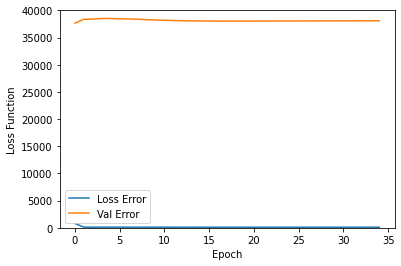

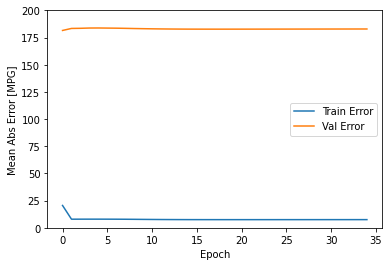

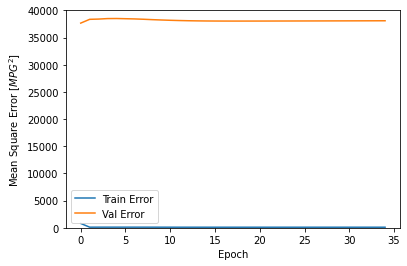

In [30]:
plot_history(history_dense, 0, 40000, 200, 40000)

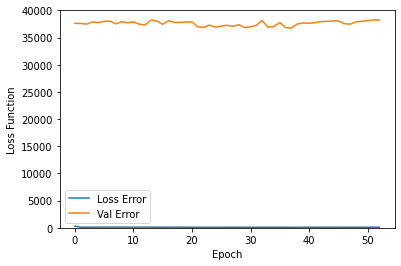

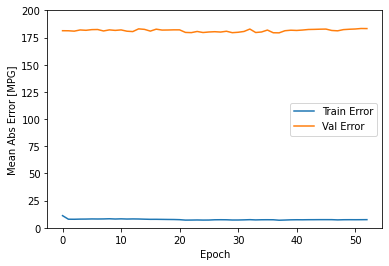

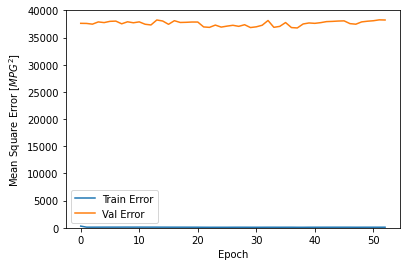

In [31]:
plot_history(history_lstm, 0, 40000, 200, 40000)

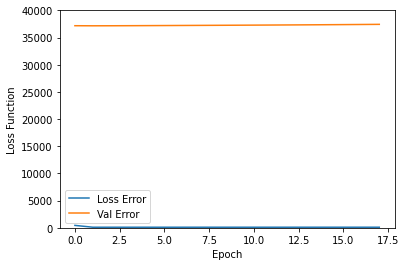

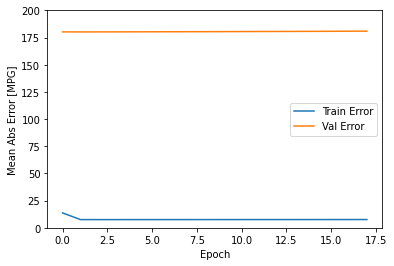

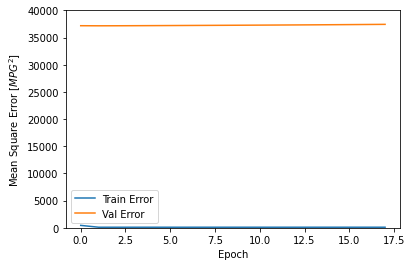

In [32]:
plot_history(history_cnn, 0, 40000, 200, 40000)

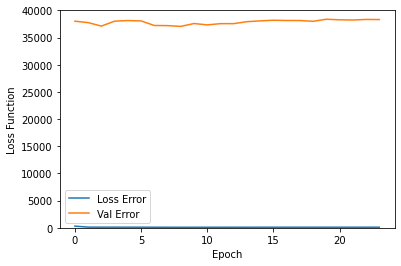

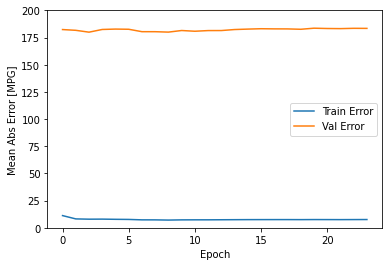

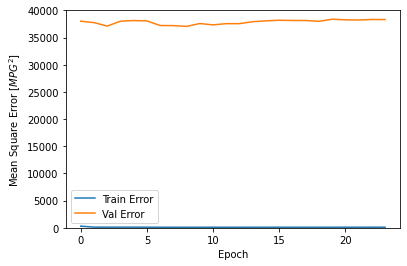

In [33]:
plot_history(history_gru, 0, 40000, 200, 40000)

In [34]:
y_pred_dense = model_dense.predict(x_test)
y_pred_lstm = model_lstm.predict(x_test)
y_pred_cnn = model_cnn.predict(x_test)
y_pred_gru = model_gru.predict(x_test)

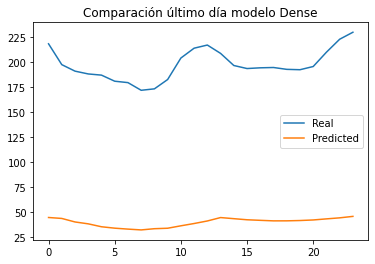

In [35]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_dense[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo Dense")
plt.legend()

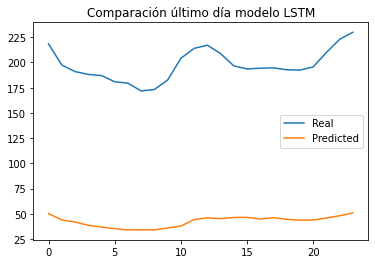

In [36]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM")
plt.legend()

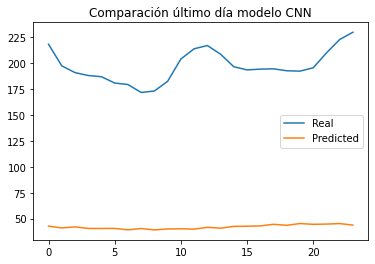

In [37]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_cnn[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo CNN")
plt.legend()

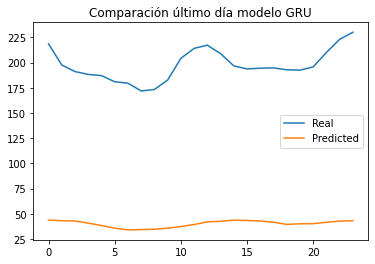

In [38]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_gru[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo GRU")
plt.legend()

In [39]:
rmse_dense = np.sqrt(mean_squared_error(y_test, y_pred_dense))
mae_dense = mean_absolute_error(y_test, y_pred_dense)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)

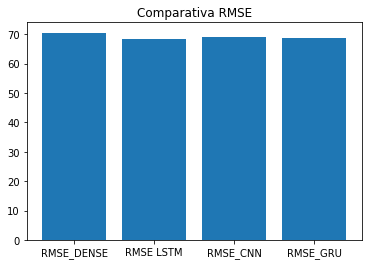

In [40]:
x_axis = ["RMSE_DENSE", "RMSE LSTM", "RMSE_CNN", "RMSE_GRU"]
y_axis = [rmse_dense, rmse_lstm, rmse_cnn, rmse_gru]
plt.title("Comparativa RMSE")
plt.bar(x_axis, y_axis)
plt.show()

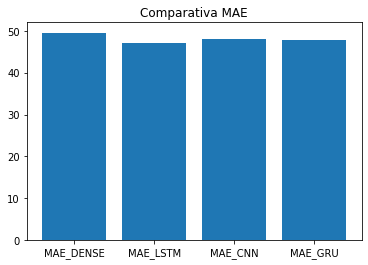

In [41]:
x_axis = ["MAE_DENSE", "MAE_LSTM", "MAE_CNN", "MAE_GRU"]
y_axis = [mae_dense, mae_lstm, mae_cnn, mae_gru]
plt.title("Comparativa MAE")
plt.bar(x_axis, y_axis)
plt.show()

In [42]:
model_dense.save("no_normalized_x_y/dense.h5")
model_lstm.save("no_normalized_x_y/lstm.h5")
model_cnn.save("no_normalized_x_y/cnn.h5")
model_gru.save("no_normalized_x_y/gru.h5")